# Outage Severity Across the U.S.: Predicting Risk Factors Behind Major Power Failures

** Yuxing Liu, Rocio Saez

**Website Link**:

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'
import seaborn as sns
import matplotlib.pyplot as plt

# from dsc80_utils import * # Feel free to uncomment and use this.

## Step 1: Introduction

- What are the characteristics of major power outages with higher severity? Variables to consider include location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics, etc. What risk factors may an energy company want to look into when predicting the location and severity of its next major power outage?

- Predict the severity (in terms of number of customers, duration, or demand loss) of a major power outage.
add a duration using the start adn 
single variable analysis : time trend, location and cause 
bivariate analysis outage duration and cause category, how server it is based on the location and duration, how lomg does each causes usually last. see if the states in certain region has a correratltion?  performed grouping with a pivot table, on Climate Region and Cause Category to see which regions experienced severe weather outages the most.
different cause and what's the most likely cause for that region and feedback based on that. (Risk)

show the NaN table. where has the most customer and where they should close.Missingness Dependency 
Cause Category
First, I examine the distribution of Cause Category when Duration is missing vs not missing.

Null Hypothesis: The distribution of Cause Category is the same when Duration is missing vs not missing.
indicating that the missingness of Duration is dependent on Cause Category. Null Hypothesis: The distribution of Month is the same when Duration is missing vs not missing.

Alternate Hypothesis: The distribution of Month is different when Duration is missing vs not missing.

hypothesis testing: cause relate to duration, if it comes from the same distribution 

hypothesies test on if the region impact on if they have the certain cause. 

# Step 2 EDA (Clean the data appropriately. For instance, you may need to replace data that should be missing with NaN or create new columns out of given ones (e.g. compute distances, scale data, or get time information from time stamps).)
Data Cleaning

### Column Removal
I removed the first three row of the data that includes the side note information about this dataset and the unit row
The following land-use variables related to total land area and water surface were dropped from the dataset:
The following columns related to state-level economic output (e.g., GSP, utility sector contribution) were dropped:
- PC.REALGSP.STATE, PC.REALGSP.USA, PC.REALGSP.REL, PC.REALGSP.CHANGE
- UTIL.REALGSP, TOTAL.REALGSP, UTIL.CONTRI, PI.UTIL.OFUSA

These variables are valuable for economic resilience or investment-focused studies, but they were not directly relevant to my focus on outage severity and its common causes by region. My analysis emphasizes event characteristics, regional climate, electricity use, and land/population patterns.


- AREAPCT_URBAN, AREAPCT_UC, PCT_LAND, PCT_WATER_TOT, PCT_WATER_INLAND

These variables, while informative, were not directly relevant to my research question about outage severity. Since my focus is on population density, climate, electricity use, and economic characteristics, I retained variables more closely tied to human impact and energy infrastructure rather than surface geography.


In [12]:
df = pd.read_csv('outage.csv')
cols_to_drop = [
    'AREAPCT_URBAN', 
    'AREAPCT_UC', 
    'PCT_LAND', 
    'PCT_WATER_TOT', 
    'PCT_WATER_INLAND',
    'PC.REALGSP.STATE',
    'PC.REALGSP.USA',
    'PC.REALGSP.REL',
    'PC.REALGSP.CHANGE',
    'UTIL.REALGSP',
    'TOTAL.REALGSP',
    'UTIL.CONTRI',
    'PI.UTIL.OFUSA'
]
df.head()
df.shape


(1534, 56)

In [13]:
#seeing the NaN in the df 
nan_counts = df.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print(nan_counts)

HURRICANE.NAMES            1462
DEMAND.LOSS.MW              705
CAUSE.CATEGORY.DETAIL       471
CUSTOMERS.AFFECTED          443
OUTAGE.RESTORATION.DATE      58
OUTAGE.RESTORATION.TIME      58
OUTAGE.DURATION              58
RES.SALES                    22
TOTAL.PRICE                  22
IND.PRICE                    22
COM.PRICE                    22
TOTAL.SALES                  22
RES.PRICE                    22
IND.SALES                    22
RES.PERCEN                   22
COM.PERCEN                   22
IND.PERCEN                   22
COM.SALES                    22
POPDEN_UC                    10
POPDEN_RURAL                 10
OUTAGE.START.TIME             9
OUTAGE.START.DATE             9
CLIMATE.CATEGORY              9
ANOMALY.LEVEL                 9
MONTH                         9
CLIMATE.REGION                6
dtype: int64


Since one of the key goals of this project is to understand the **severity** of major power outages, I focus on three main severity metrics: 

- `CUSTOMERS.AFFECTED`
- `DEMAND.LOSS.MW`
- `OUTAGE.DURATION`

Among these, `OUTAGE.DURATION` (measured in minutes) is a direct indicator of how long an outage lasted — a critical dimension of impact for residents, businesses, and infrastructure. An outage without a known duration cannot be meaningfully compared or modeled for severity.

Therefore, I dropped all rows with missing values in the `OUTAGE.DURATION` column. These rows (58 total) represent cases where the restoration time was either not recorded or not reported, making them unsuitable for this analysis focused on quantifying outage severity.


In [14]:
df = df.dropna(subset=['OUTAGE.DURATION'])
df.shape


(1476, 56)

The power outage start date and time is given by 'OUTAGE.START.DATE' and 'OUTAGE.START.TIME'. I convert these two columns were combined into one pd.Timestamp column. Combine 'OUTAGE.START.DATE' and 'OUTAGE.START.TIME' into a new pd.Timestamp column called 'OUTAGE.START'. Similarly, combine 'OUTAGE.RESTORATION.DATE' and 'OUTAGE.RESTORATION.TIME' into a new pd.Timestamp column called 'OUTAGE.RESTORATION'.

In [19]:
df['OUTAGE.START.DATE'] = pd.to_datetime(df['OUTAGE.START.DATE'], errors='coerce')
df['OUTAGE.RESTORATION.DATE'] = pd.to_datetime(df['OUTAGE.RESTORATION.DATE'], errors='coerce')

# Convert time columns (assumed to be in HH:MM or HH:MM:SS format) into timedeltas
df['OUTAGE.START.TIME'] = pd.to_timedelta(df['OUTAGE.START.TIME'], errors='coerce')
df['OUTAGE.RESTORATION.TIME'] = pd.to_timedelta(df['OUTAGE.RESTORATION.TIME'], errors='coerce')

# Combine to create full timestamp columns
df['OUTAGE.START'] = df['OUTAGE.START.DATE'] + df['OUTAGE.START.TIME']
df['OUTAGE.RESTORATION'] = df['OUTAGE.RESTORATION.DATE'] + df['OUTAGE.RESTORATION.TIME']

In [20]:
df.head()

,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 05:00:00,2011-07-03 08:00:00
1,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 06:38:00,2014-05-11 06:39:00
2,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 08:00:00,2010-10-28 10:00:00
3,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 11:00:00
4,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00


# Step 2 EDA (Look at the distributions of relevant columns separately by using DataFrame operations and drawing at least two relevant plots.)
Univariate Analysis

This bar chart displays the distribution of major power outages across different cause categories. The most common cause by far is severe weather, followed by intentional attacks and system operability disruptions. This highlights the significant impact of natural events and security threats on the power grid. Understanding the dominant causes helps utilities prioritize infrastructure improvements and disaster response strategies.



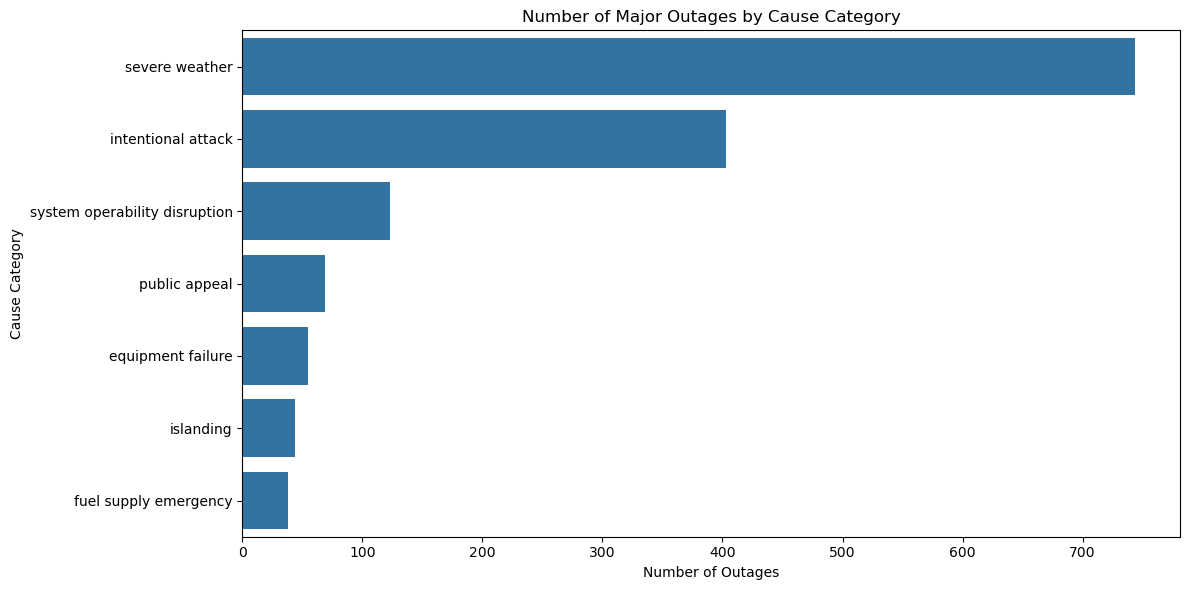

In [21]:
# Count number of outages per cause category

plt.figure(figsize=(12, 6))
sns.countplot(y='CAUSE.CATEGORY', data=df, order=df['CAUSE.CATEGORY'].value_counts().index)
plt.title('Number of Major Outages by Cause Category')
plt.xlabel('Number of Outages')
plt.ylabel('Cause Category')
plt.tight_layout()
plt.show()


This plot shows the number of major outages by U.S. state from 2000 to 2016. California leads with the highest number of outages, followed by Texas, Michigan, and Washington. States with large populations, varied terrain, or weather exposure tend to experience more frequent outages. The long tail of the distribution shows many states with relatively few major outages, indicating regional variation in outage frequency.

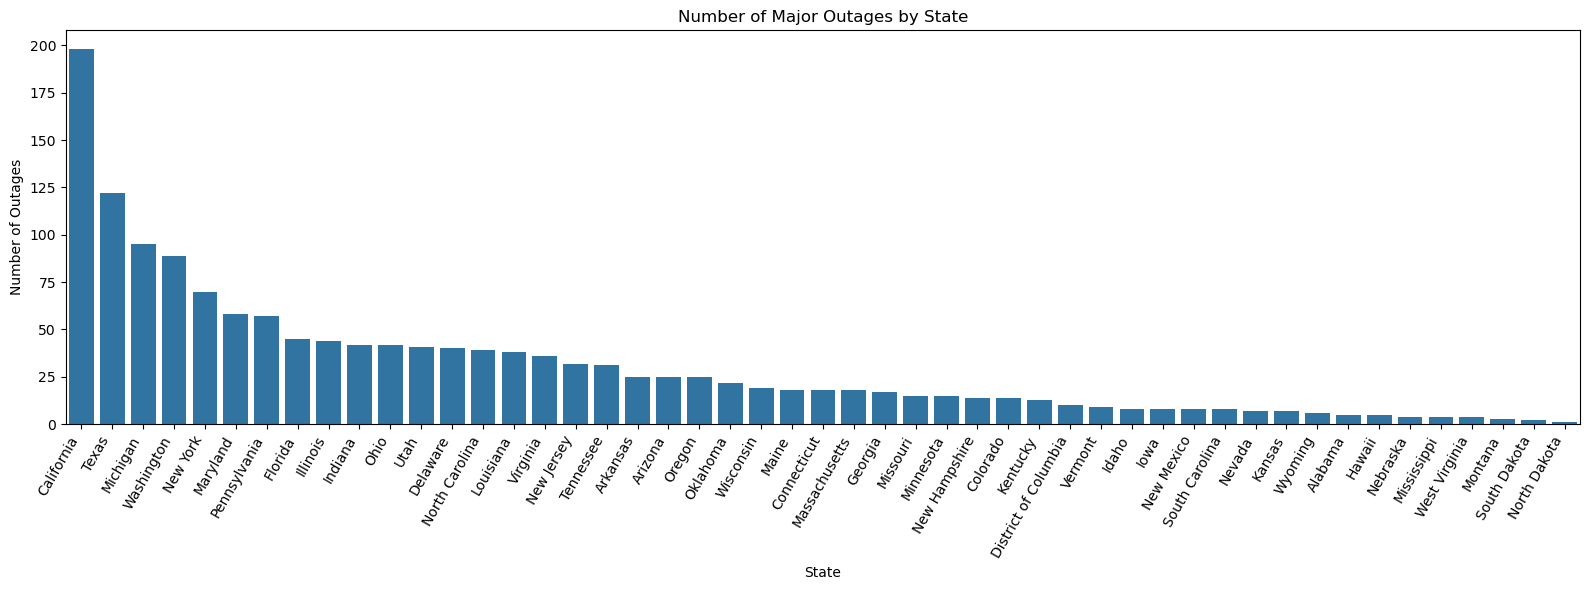

In [22]:
plt.figure(figsize=(16, 6))
sns.countplot(x='U.S._STATE', data=df, order=df['U.S._STATE'].value_counts().index)
plt.title('Number of Major Outages by State')
plt.xlabel('State')
plt.ylabel('Number of Outages')
plt.xticks(rotation=60, ha='right')  # Rotate for readability
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import folium
import requests

# Step 1: Aggregate number of outages per state
# Mapping of full state names to postal abbreviations
state_abbrev = {
    'Alabama': 'AL', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL',
    'Georgia': 'GA', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI',
    'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND',
    'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Fix the mismatch
state_counts['state_code'] = state_counts['state'].map(state_abbrev)

# Create map
m = folium.Map(location=[37.8, -96], zoom_start=4)

# Add choropleth
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_counts,
    columns=['state_code', 'num_outages'],
    key_on='feature.id',
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Major Power Outages'
).add_to(m)

m  # Display in Jupyter



# Step 2 EDA 
Bivariate Analysis(Look at the statistics of pairs of columns to identify possible associations. For instance, you may create scatter plots and plot conditional distributions, or box-plots. You must plot at least two such plots in your notebook. The results of your bivariate analyses will be helpful in identifying interesting hypothesis tests!)

Are certain climate regions more prone to severe outages (longer duration or more affected customers)?

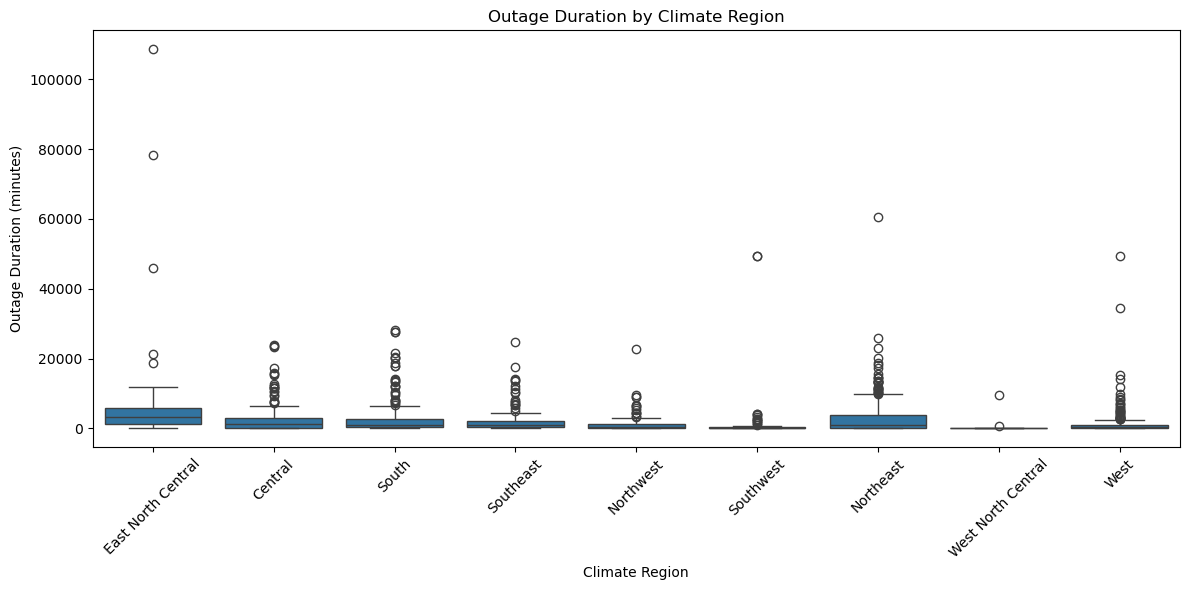

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop NA for clean plotting
df_climate = df.dropna(subset=['CLIMATE.REGION', 'OUTAGE.DURATION'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_climate, x='CLIMATE.REGION', y='OUTAGE.DURATION')
plt.title('Outage Duration by Climate Region')
plt.xlabel('Climate Region')
plt.ylabel('Outage Duration (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This box plot shows how outage duration varies across different U.S. climate regions. The East North Central and Northeast regions display longer and more variable outage durations, as seen from the wider spread and presence of high outliers. This suggests that regional climate factors—like extreme snow or storms—may affect how long it takes to restore power.

 Is there a relationship between % urban population (POPPCT_URBAN) and severity?

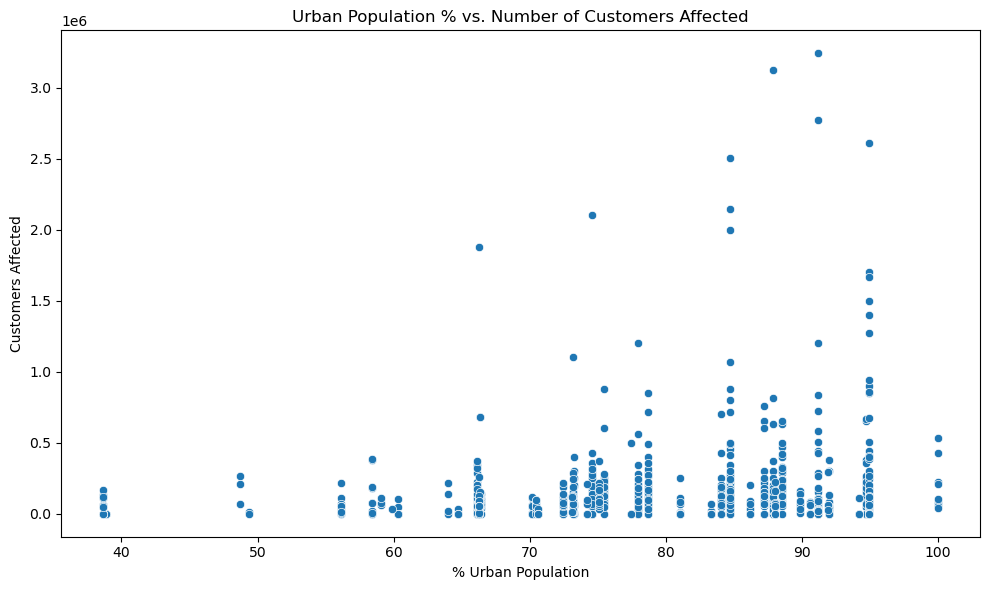

In [30]:
# Drop NA values for plotting
df_urban = df.dropna(subset=['POPPCT_URBAN', 'CUSTOMERS.AFFECTED'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_urban, x='POPPCT_URBAN', y='CUSTOMERS.AFFECTED')
plt.title('Urban Population % vs. Number of Customers Affected')
plt.xlabel('% Urban Population')
plt.ylabel('Customers Affected')
plt.tight_layout()
plt.show()


This scatter plot explores the relationship between how urban a state is and how many customers are affected during major outages. While most outages cluster below 1 million affected customers, there is a noticeable upward spread in highly urbanized states (above 80% urban population), suggesting denser regions might be more vulnerable to large-scale service disruption.

Do outages in summer or winter tend to be longer or larger?

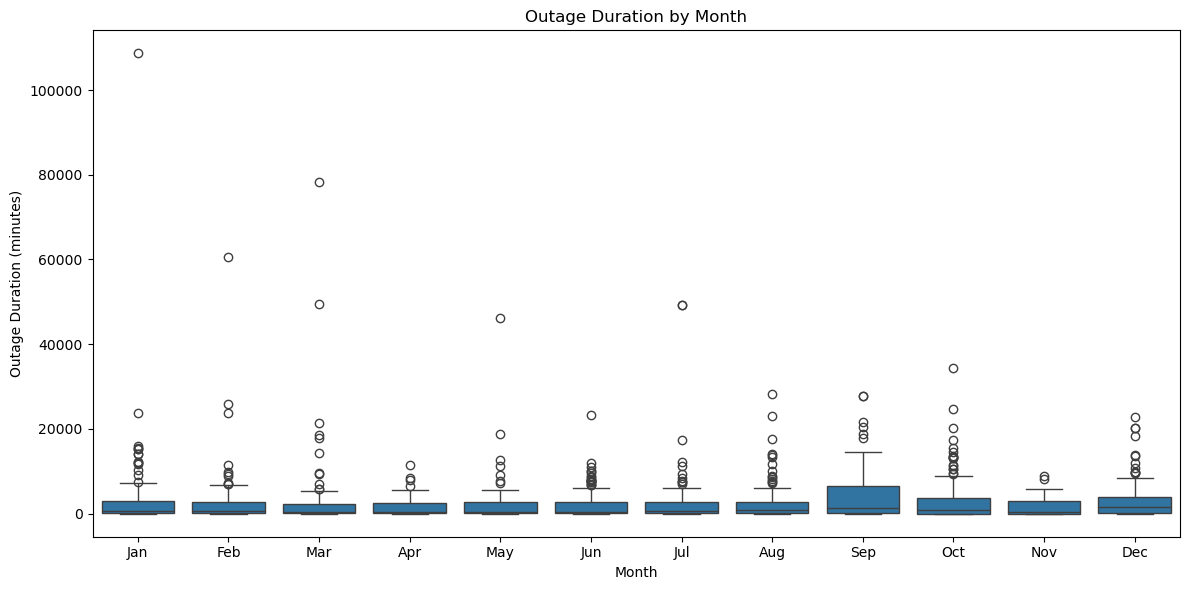

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values
df_month = df.dropna(subset=['MONTH', 'OUTAGE.DURATION'])

# Sort months numerically for correct x-axis order
df_month['MONTH'] = df_month['MONTH'].astype(int)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_month, x='MONTH', y='OUTAGE.DURATION')
plt.title('Outage Duration by Month')
plt.xlabel('Month')
plt.ylabel('Outage Duration (minutes)')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()


This box plot breaks down outage duration by month to reveal potential seasonal effects. August, September, and October show slightly higher median durations and more high-end outliers, which may correspond to peak storm or hurricane seasons. These findings suggest that certain months may require increased readiness and response resources.

# Step 2 EDA Choose columns to group and pivot by and examine aggregate statistics.
Interesting Aggregates

How does the average duration of outages vary by cause and region?

In [33]:
pivot_cause_region = pd.pivot_table(
    df,
    values='OUTAGE.DURATION',
    index='CLIMATE.REGION',
    columns='CAUSE.CATEGORY',
    aggfunc='mean'
)

pivot_cause_region.round(1)


CAUSE.CATEGORY,equipment failure,fuel supply emergency,intentional attack,islanding,public appeal,severe weather,system operability disruption
CLIMATE.REGION,,,,,,,
Central,322.0,10035.2,346.1,125.3,1410.0,3250.0,2695.2
East North Central,26435.3,33971.2,2376.0,1.0,733.0,4434.8,2610.0
Northeast,215.8,14629.6,196.0,881.0,2655.0,4429.9,773.5
Northwest,702.0,1.0,373.8,73.3,898.0,4838.0,141.0
South,295.8,17482.5,325.6,493.5,1164.0,4391.3,866.1
Southeast,554.5,NaN,504.7,NaN,2865.4,2662.6,169.3
Southwest,113.8,76.0,265.7,2.0,2275.0,11572.9,329.2
West,524.8,6154.6,857.7,214.9,2028.1,2928.4,363.7
West North Central,61.0,NaN,23.5,68.2,439.5,2442.5,NaN


This pivot table reveals clear regional patterns in how long major power outages last, depending on their cause. For instance:

Severe weather causes especially long outages in the Southwest and Northwest (11,572.9 and 4,838.0 minutes, respectively).

Fuel supply emergencies lead to very prolonged outages in East North Central and South.

Outages due to equipment failure are unusually high in East North Central, potentially pointing to aging or fragile infrastructure.

The regional disparities underscore that the same cause may have drastically different impacts depending on local conditions, infrastructure readiness, and climate challenges. This insight can guide location-specific planning for utilities and policymakers.

# Step 3: Assessment of Missingness
NMAR Analysis(Recall, to determine whether data are likely NMAR, you must reason about the data generating process; you cannot conclude that data are likely NMAR solely by looking at your data. As such, there’s no code to write here (and hence, nothing to put in your notebook).)

I believe the column CUSTOMERS.AFFECTED is likely Not Missing At Random (NMAR). This is because the decision to leave the value blank may depend on the value itself — for example, if only a small number of customers were affected and the utility deemed it not worth reporting. In such cases, the missingness depends directly on the (unseen) value of CUSTOMERS.AFFECTED, making it NMAR.

To determine if this missingness could instead be MAR, we would need additional metadata about the reporting policies or criteria used by each utility during the event, such as thresholds for whether customer impact was logged.

# Step 3: Assessment of Missingness
Missingness Dependency (Pick a column in the dataset with non-trivial missingness to analyze, and perform permutation tests to analyze the dependency of the missingness of this column on other columns.

Specifically, find at least one other column that the missingness of your selected column does depend on, and at least one other column that the missingness of your selected column does not depend on.

Tip: Make sure you know the difference between the different types of missingness before approaching that section. Many students in the past have lost credit for mistaking one type of missingness for another.

Note that some datasets may have special requirements for this section; look at the “Special Considerations” section of your chosen dataset for more details.)

Does DEMAND.LOSS.MW Missingness Depend on CAUSE.CATEGORY?
We test if the missing values are related to the cause of the outage.

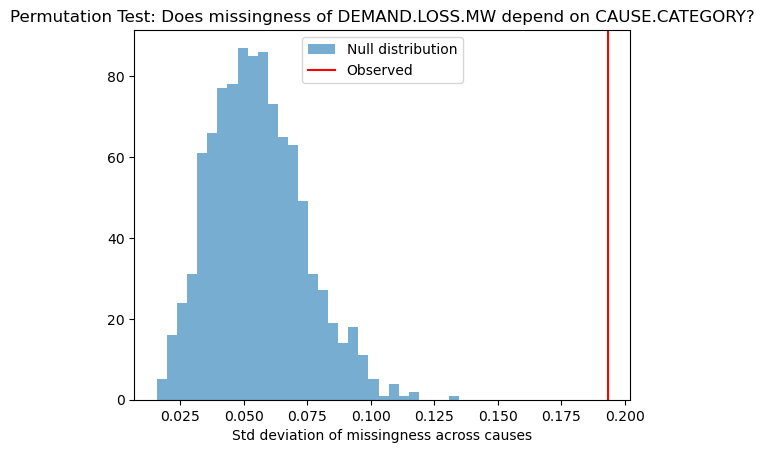

P-value: 0.0000


In [38]:
df['DEMAND_MISSING'] = df['DEMAND.LOSS.MW'].isna()

obs_stat = df.groupby('CAUSE.CATEGORY')['DEMAND_MISSING'].mean().std()

stats = []
for _ in range(1000):
    shuffled = df['DEMAND_MISSING'].sample(frac=1, replace=False).reset_index(drop=True)
    stat = df.assign(shuffled=shuffled).groupby('CAUSE.CATEGORY')['shuffled'].mean().std()
    stats.append(stat)

plt.hist(stats, bins=30, alpha=0.6, label='Null distribution')
plt.axvline(obs_stat, color='red', label='Observed')
plt.xlabel('Std deviation of missingness across causes')
plt.title('Permutation Test: Does missingness of DEMAND.LOSS.MW depend on CAUSE.CATEGORY?')
plt.legend()
plt.show()

p_val = np.mean([s >= obs_stat for s in stats])
print(f"P-value: {p_val:.4f}")



As seen in the histogram (see above), the observed standard deviation is far outside the range of the null distribution, with a p-value < 0.001.

This indicates that missingness in DEMAND.LOSS.MW is dependent on CAUSE.CATEGORY, suggesting Missing At Random (MAR). In other words, the missingness can be explained by another observed column.

Test Missingness of DEMAND.LOSS.MW vs. U.S._STATE

<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

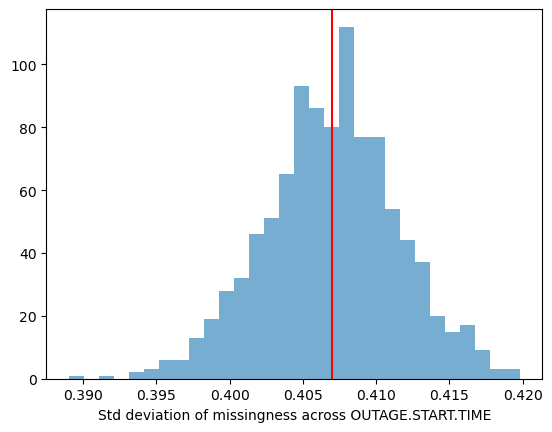

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Indicator column for missingness
df['DEMAND_MISSING'] = df['DEMAND.LOSS.MW'].isna()

# Step 2: Drop rows where OUTAGE.START.TIME is missing
valid_df = df.dropna(subset=['OUTAGE.START.TIME'])

# Step 3: Observed statistic (std dev of mean missingness across times)
obs_std = valid_df.groupby('OUTAGE.START.TIME')['DEMAND_MISSING'].mean().std()

# Step 4: Permutation test
stats = []
for _ in range(1000):
    shuffled = valid_df['DEMAND_MISSING'].sample(frac=1, replace=False).reset_index(drop=True)
    stat = valid_df.assign(shuffled=shuffled).groupby('OUTAGE.START.TIME')['shuffled'].mean().std()
    stats.append(stat)

# Step 5: Plot
plt.hist(stats, bins=30, alpha=0.6, label='Null distribution')
plt.axvline(obs_std, color='red', label='Observed')
plt.xlabel('Std deviation of missingness across OUTAGE.START.TIME')
plt.title



We conducted a permutation test to assess whether the missingness in the DEMAND.LOSS.MW column depends on OUTAGE.START.TIME. The test statistic (standard deviation of missingness across times) closely matches the null distribution generated by permutation.

Since the observed value is not extreme and falls well within the range of expected variation under the null hypothesis, we conclude that the missingness does not depend on OUTAGE.START.TIME.

Therefore, with respect to this column, the missingness is consistent with Missing Completely At Random (MCAR).

# Step 4 Hypothesis 
Clearly state a pair of hypotheses and perform a hypothesis test or permutation test that is not related to missingness. Feel free to use one of the example questions stated in the “Example Questions and Prediction Problems” section of your dataset’s description page or pose a hypothesis test of your own.

Hypothesis Test: Are summer outages more severe?
Null Hypothesis (H₀): Outages in summer are not longer than outages in other seasons.

Alternative Hypothesis (H₁): Outages in summer have significantly greater durations than those in other seasons.

/var/folders/x3/njtmx_xx2kq6t3cql4c1pk9r0000gn/T/ipykernel_13541/1246166289.py:29: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



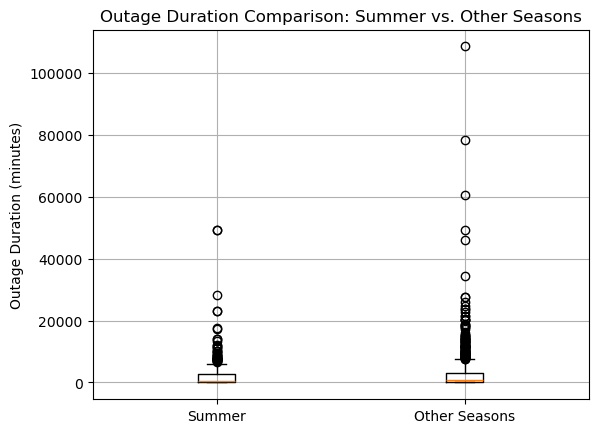

Test statistic: 247193.00
P-value: 0.5021


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# Categorize MONTH into SEASON
def get_season(month):
    if month in [6, 7, 8]:
        return 'Summer'
    elif month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    else:
        return 'Fall'

df['SEASON'] = df['MONTH'].apply(get_season)

# Drop rows with missing OUTAGE.DURATION
season_df = df.dropna(subset=['OUTAGE.DURATION', 'SEASON'])

# Compare Summer vs. all other seasons
summer_durations = season_df[season_df['SEASON'] == 'Summer']['OUTAGE.DURATION']
other_durations = season_df[season_df['SEASON'] != 'Summer']['OUTAGE.DURATION']

# Run Mann-Whitney U test (non-parametric)
stat, p_value = mannwhitneyu(summer_durations, other_durations, alternative='greater')

# Plot
plt.boxplot([summer_durations, other_durations], labels=['Summer', 'Other Seasons'])
plt.title('Outage Duration Comparison: Summer vs. Other Seasons')
plt.ylabel('Outage Duration (minutes)')
plt.grid(True)
plt.show()

print(f"Test statistic: {stat:.2f}")
print(f"P-value: {p_value:.4f}")


There is no significant evidence that power outages in summer are longer than those in other seasons. The distribution of durations appears similar across seasons based on the boxplot and statistical test.

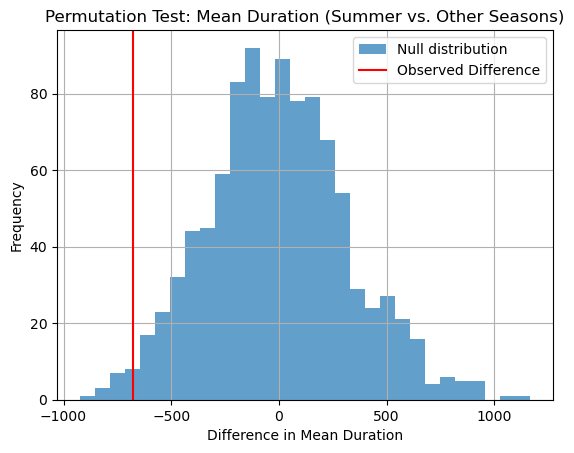

Permutation p-value: 0.9850


In [45]:
# Observed difference in mean durations
observed_diff = summer_durations.mean() - other_durations.mean()

# Initialize list for null distribution
diffs = []

# Permutation loop
for _ in range(1000):
    shuffled = season_df['SEASON'].sample(frac=1, replace=False).values  # preserve positional index
    summer_group = season_df['OUTAGE.DURATION'][shuffled == 'Summer']
    other_group = season_df['OUTAGE.DURATION'][shuffled != 'Summer']
    diffs.append(summer_group.mean() - other_group.mean())

# Compute p-value
p_value_perm = np.mean([d >= observed_diff for d in diffs])

# Plot the null distribution
plt.hist(diffs, bins=30, alpha=0.7, label='Null distribution')
plt.axvline(observed_diff, color='red', label='Observed Difference')
plt.legend()
plt.title('Permutation Test: Mean Duration (Summer vs. Other Seasons)')
plt.xlabel('Difference in Mean Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Permutation p-value: {p_value_perm:.4f}")


We fail to reject the null hypothesis. There is no statistically significant evidence that outages in summer are more severe (longer in duration) than those in other seasons.

# Step 5: Framing a Prediction Problem
Identify a prediction problem. Feel free to use one of the example prediction problems stated in the “Example Questions and Prediction Problems” section of your dataset’s description page or pose a hypothesis test of your own. The prediction problem you come up with doesn’t have to be related to the question you were answering in Steps 1-4, but ideally, your entire project has some sort of coherent theme.

Predict the severity of a major power outage in terms of outage duration (in minutes), based on characteristics such as the region, climate, time, and cause category.

In [ ]:
# Step 

idea: make a map of where alll the power outages are. show by serverity by region. Folium package. 

In [ ]:
# TODO

## Step 2: Data Cleaning and Exploratory Data Analysis

In [ ]:
# TODO

## Step 3: Assessment of Missingness

In [ ]:
# TODO

## Step 4: Hypothesis Testing

In [ ]:
# TODO

## Step 5: Framing a Prediction Problem

In [ ]:
# TODO

## Step 6: Baseline Model

In [ ]:
# TODO

## Step 7: Final Model

In [ ]:
# TODO

## Step 8: Fairness Analysis

In [ ]:
# TODO